In [127]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import warnings
warnings.filterwarnings('ignore')

In [2]:
demographics = pd.read_csv('ICKDemographicsPipeline_v260423.csv')
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173193 entries, 0 to 173192
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UserID          173193 non-null  object 
 1   TotalChild      173193 non-null  int64  
 2   MedianChildAge  173193 non-null  float64
 3   No.Female       173193 non-null  float64
 4   No.Male         173193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.6+ MB


In [3]:
df_pay = pd.read_csv('RealPaymentsType.csv')
df_pay['UserJoinedDate'] = df_pay['UserJoinedDate'].map(lambda x: x[: 19])
df_pay['UserJoinedDate'] = pd.to_datetime(df_pay['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
df_pay['JoinMonth'] = df_pay['UserJoinedDate'].dt.month

payment = df_pay[['UserID', 'UserJoinedDate', 'gapday']]
payment.shape

(265308, 3)

In [5]:
detail = pd.read_csv('Engagement_detail_learn_updated.csv')
detail['InteractionLearn'] = detail['UsageTime'] * detail['Records']

detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506702 entries, 0 to 1506701
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   EventDate                  1506702 non-null  object 
 1   nth_day_from_registration  1506702 non-null  int64  
 2   UserID                     1506702 non-null  object 
 3   SubjectName                1506702 non-null  object 
 4   IsCompleted                1506702 non-null  int64  
 5   UsageTime                  1506702 non-null  float64
 6   Records                    1506702 non-null  int64  
 7   InteractionLearn           1506702 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ MB


In [6]:
detail = pd.merge(left=detail,
                  right=payment,
                  how='left',
                  on='UserID')
detail.shape

(1506702, 10)

In [7]:
firstday_learn = pd.DataFrame(detail.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday_learn.columns = ['UserID', 'MinFirstDay']

firstday_learn['ZeroDay'] = firstday_learn['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday_learn.shape

(153340, 3)

In [8]:
detail = pd.merge(left=detail,
                  right=firstday_learn,
                  how='left',
                  on='UserID')

detail.loc[detail['gapday'].isnull(), 'gapday'] = 'no_pay'
detail.shape

(1506702, 12)

In [9]:
def DetailBasedNthDay(dataframe, nthday=3):
    pay = dataframe.loc[dataframe['gapday'] != 'no_pay']
    
    mask0 = pay['ZeroDay'] == 'zero'
    mask1 = pay['nth_day_from_registration'] <= nthday
    df0 = pay[mask0 & mask1]
    
    df0['CutoffDay'] = df0['MinFirstDay'] + nthday
    df0['ScaleActionDay'] = df0['nth_day_from_registration'] - 0
    df0['ScaleGapday'] = df0['gapday'] - df0['MinFirstDay']
    
    mask2 = pay['ZeroDay'] != 'zero'
    others = pay[mask2]
    others['CutoffDay'] = others['MinFirstDay'] + nthday
    
    mask3 = others['nth_day_from_registration'] <= others['CutoffDay']
    df1 = others[mask3]
    df1['ScaleActionDay'] = df1['nth_day_from_registration'] - df1['MinFirstDay']
    df1['ScaleGapday'] = df1['gapday'] - df1['MinFirstDay']
    
    purchaser = pd.concat([df0, df1], ignore_index=True)
    
    free = dataframe.loc[dataframe['gapday'] == 'no_pay']
    f0 = free['ZeroDay'] == 'zero'
    f1 = free['nth_day_from_registration'] <= nthday
    free0 = free[f0 & f1]
    
    free0['CutoffDay'] = free0['MinFirstDay'] + nthday
    free0['ScaleActionDay'] = free0['nth_day_from_registration'] - 0
    free0['ScaleGapday'] = free0['gapday']
    
    non0 = free.loc[free['ZeroDay'] != 'zero']
    non0['CutoffDay'] = non0['MinFirstDay'] + nthday
    f3 = non0['nth_day_from_registration'] <= non0['CutoffDay']
    free1 = non0[f3]
    free1['ScaleActionDay'] = free1['nth_day_from_registration'] - free1['MinFirstDay']
    free1['ScaleGapday'] = free1['gapday']
    
    non_purchaser = pd.concat([free0, free1], ignore_index=True)
    
    data = pd.concat([purchaser, non_purchaser], ignore_index=True)
    
    return data

In [10]:
learn_detail = DetailBasedNthDay(detail, nthday=3)

In [11]:
content_learn = learn_detail.pivot_table(index = 'UserID',
                                         columns = 'SubjectName',
                                         values = ['IsCompleted', 'UsageTime', 'Records', 'InteractionLearn'],
                                         aggfunc = np.sum).reset_index()

cols = ['UserID',
        'InteractionEnglish', 'InteractionMath', 'InteractionPhonics', 'InteractionVietnamese',
        'IsCompletedEnglish', 'IsCompletedMath','IsCompletedPhonics', 'IsCompletedVietnamese',
        'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
        'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

content_learn.columns = cols

for col in content_learn.columns[1:]:
    content_learn.loc[content_learn[col].isnull(), col] = 0
    
content_learn.shape

(153340, 17)

In [12]:
engage = pd.read_csv('RealEngagements_updated.csv')
engage['UserJoinedDate'] = engage['UserJoinedDate'].map(lambda x: x[: 19])
engage['UserJoinedDate'] = pd.to_datetime(engage['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')

engage['lastuse'] = engage['lastuse'].map(lambda x: x[: 19])
engage['lastuse'] = pd.to_datetime(engage['lastuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse'] = engage['firstuse'].map(lambda x: x[: 19])
engage['firstuse'] = pd.to_datetime(engage['firstuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse_hour'] = engage['firstuse'].dt.hour
engage['lastuse_hour'] = engage['lastuse'].dt.hour
engage['lastuse_day'] = engage['lastuse'].dt.day
engage['lastuse_dayofweek'] = engage['lastuse'].dt.dayofweek
engage['JoinMonth'] = engage['UserJoinedDate'].dt.month

engage.shape

(1638631, 17)

In [13]:
engage = pd.merge(left=engage,
                  right=payment[['UserID', 'gapday']],
                  on='UserID',
                  how='left')
engage.shape

(1638631, 18)

In [14]:
brand = engage['DeviceBrand'].value_counts()

Big = brand[brand >= 100000].index.tolist()
Medium = brand[(brand >= 10000) & (brand < 100000)].index.tolist()
Small = brand[brand < 10000].index.tolist()

def TransformBrand(x):
    if x in Big:
        return 'Big'
    elif x in Medium:
        return 'Medium'
    else:
        return 'Small'

engage['TypeBrand'] = engage['DeviceBrand'].map(lambda x: TransformBrand(x))

engage.loc[engage['gapday'].isnull(), 'gapday'] = 'no_pay'

In [15]:
firstday = pd.DataFrame(engage.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday.columns = ['UserID', 'MinFirstDay']

firstday['ZeroDay'] = firstday['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday.shape

(163040, 3)

In [16]:
engage = pd.merge(left=engage,
                  right=firstday,
                  how='left',
                  on='UserID')
engage.shape

(1638631, 21)

In [17]:
action = DetailBasedNthDay(engage, nthday=3)

In [18]:
action.shape

(433980, 24)

In [19]:
Recency = lambda x: 4 - max(x)

Frequency_content = lambda x: len(x.unique()) # tan suat dang nhap trong 2 ngay
Frequency_payment = lambda x: sum(x)# so lan vao trang thanh toan trong 2 ngay

Monetary_usage = lambda x: sum(x)  # tong thoi gian dung app trong 7 ngay (minutes)
Monetary_record = lambda x: sum(x) # tong so records trong 7 ngay

Mode_firstuse_hour = lambda x: x.mode()[0]
Mode_lastuse_day = lambda x: x.mode()[0]
Mode_lastuse_hour = lambda x: x.mode()[0]
Mode_lastuse_dayofweek = lambda x: x.mode()[0]

active = action.groupby('UserID').agg({'ScaleActionDay': Recency,
                                     'firstuse': Frequency_content,
                                     'payment_screen_time': Frequency_payment,
                                     'UsageTime': Monetary_usage,
                                     'Records': Monetary_record,
                                     'firstuse_hour': Mode_firstuse_hour,
                                     'lastuse_hour': Mode_lastuse_hour,
                                     'lastuse_day': Mode_lastuse_day,
                                     'lastuse_dayofweek': Mode_lastuse_dayofweek}).reset_index()

cols = ['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 
        'TotalUsageTime','TotalRecords', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay', 'ModeDayofweek']

active.columns = cols

In [20]:
Median_usage = lambda x: x.median()
Median_record = lambda x: x.median()
Median_payment_screentime = lambda x: x.median()

active_median = action.groupby('UserID').agg({'UsageTime': Median_usage,
                                            'Records': Median_record,
                                            'payment_screen_time': Median_payment_screentime}).reset_index()

cols = ['UserID', 'MedianUsageTime', 'MedianRecord', 'MedianPaymentScreen']

active_median.columns = cols

In [21]:
action['Counting'] = [1] * action.shape[0]

brand = action.pivot_table(index = 'UserID',
                             columns = 'TypeBrand',
                             values = ['Counting'],
                             aggfunc = np.sum).reset_index()

brand_cols = ['UserID', 'BigBrand', 'MediumBrand', 'SmallBrand']
        
brand.columns = brand_cols

for col in brand.columns[1:]:
    brand.loc[brand[col].isnull(), col] = 0
    
brand.shape

(163040, 4)

In [22]:
content_sum = action.pivot_table(index = 'UserID',
                                    columns = 'ActionType',
                                    values = ['UsageTime', 'Records'],
                                    aggfunc = np.sum).reset_index()

new_cols = ['UserID',
            'RecordDiscovery', 'RecordEntertainment', 'RecordLearn',
            'UsageTimeDiscovery', 'UsageTimeEntertainment', 'UsageTimeLearn']

content_sum.columns = new_cols

for col in content_sum.columns[1:]:
    content_sum.loc[content_sum[col].isnull(), col] = 0

In [23]:
Number_of_device = lambda x: len(x.unique())

demo = action.groupby('UserID').agg({'TypeBrand': Number_of_device}).reset_index()

demo.columns = ['UserID', 'No.TypeBrand']

demo

,UserID,No.TypeBrand
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,1
1,00007f9f-be36-4a0d-a2a8-167231588625,1
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1
3,0001f256-edcf-4980-b84b-85d85745fd0f,1
4,000234a9-a233-4476-9023-9b83f331b7f6,1
...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,1
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,1
163037,ffff56de-effe-4b67-9990-33240f51c866,1
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1


In [24]:
print(active.shape)
print(content_sum.shape)
print(active_median.shape)
print(brand.shape)
print(content_learn.shape)
print(demo.shape)
print(demographics.shape)

(163040, 10)
(163040, 7)
(163040, 4)
(163040, 4)
(153340, 17)
(163040, 2)
(173193, 5)


In [25]:
data_list = [active, demographics, demo, brand, content_learn, content_sum, active_median, 
             df_pay[['UserID', 'firstPaymentType', 'JoinMonth','gapday']]]

final = active.copy()

for x in data_list[1:]:
    final = pd.merge(left=final,
                     right=x,
                     how='left',
                     on='UserID')
final.shape

(163040, 46)

In [26]:
null_idx = final.loc[final['TotalChild'].isnull()].index.tolist()

final = final.drop(null_idx)
final.shape

(158981, 46)

In [184]:
data = final.copy()

In [185]:
learning_detail = ['InteractionEnglish', 'InteractionMath','InteractionPhonics', 'InteractionVietnamese', 
                   'IsCompletedEnglish', 'IsCompletedMath', 'IsCompletedPhonics', 'IsCompletedVietnamese',
                   'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
                   'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

for col in learning_detail:
    data.loc[data[col].isnull(), col] = 0

In [186]:
data['AvgTimePerCompletion'] = data['TotalUsageTime'] / data['TotalRecords']
data['InteractionGeneral'] = data['TotalUsageTime'] * data['TotalRecords']
data['InteractionLearn'] = data['UsageTimeLearn'] * data['RecordLearn']
data['InteractionDiscovery'] = data['UsageTimeDiscovery'] * data['RecordDiscovery']
data['InteractionEntertainment'] = data['UsageTimeEntertainment'] * data['RecordEntertainment']
data['MedianInteraction'] = data['MedianUsageTime'] * data['MedianRecord']

In [187]:
data['Label'] = data['gapday'].map(lambda x: 1 if x <= 31 else 0)

data['Label'].value_counts()

0    148681
1     10300
Name: Label, dtype: int64

In [188]:
data1 = data.copy()

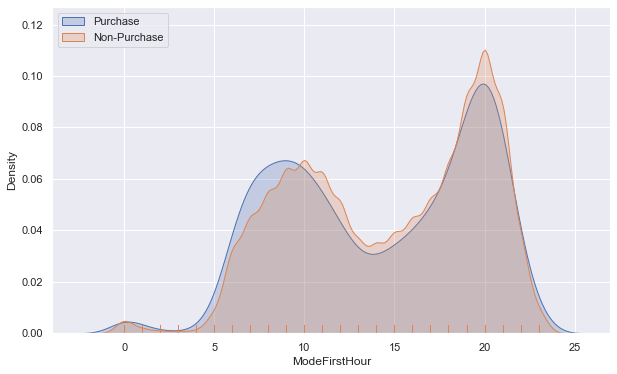

In [33]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

In [189]:
excludes = ['firstPaymentType', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 'TotalChild', 
            'MedianChildAge', 'No.Female', 'No.Male', 'No.TypeBrand', 'BigBrand', 'MediumBrand',
            'SmallBrand', 'Label', 'gapday', 'JoinMonth', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay',
            'ModeDayofweek']

for col in data.columns[1:]:
    if col not in excludes:
        if data[col].min() == 0:
            data[col] = data[col] + 1
            data[col] = np.log(data[col])
        else:
            data[col] = np.log(data[col])

In [190]:
data.to_csv('ICK_Active3thdays.csv', index=False)

----- TotalUsageTime -----
count    158981.000000
mean          2.621049
std           1.277185
min           0.000000
25%           1.609438
50%           2.691243
75%           3.578227
max           7.377984
Name: TotalUsageTime, dtype: float64
* Variance: 1.6312006916978088
* Median: 2.691243082785829
* Skewness: -0.005237658501489287
* Kurtosis: -0.785925879240454
* Percentage of outliers: 7.548071782162648e-05
* Number of missing value: 0


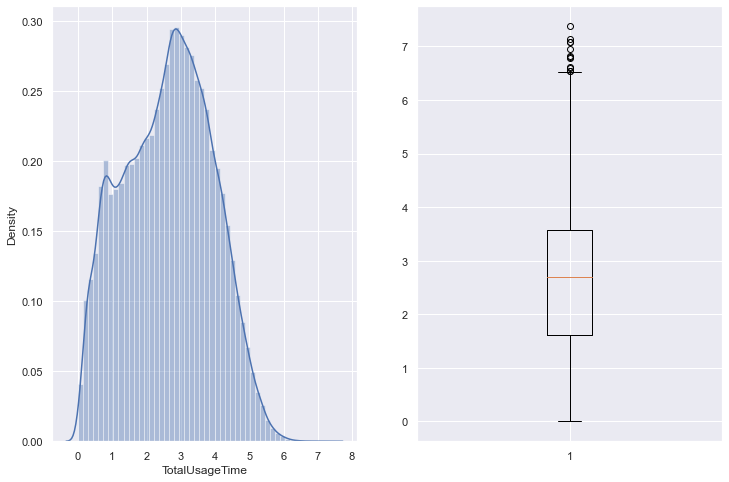


----- TotalRecords -----
count    158981.000000
mean          2.515903
std           1.311774
min           0.000000
25%           1.609438
50%           2.639057
75%           3.496508
max           6.753438
Name: TotalRecords, dtype: float64
* Variance: 1.7207517500437848
* Median: 2.6390573296152584
* Skewness: -0.21029484807301246
* Kurtosis: -0.664799764720883
* Percentage of outliers: 4.4030418729282114e-05
* Number of missing value: 0


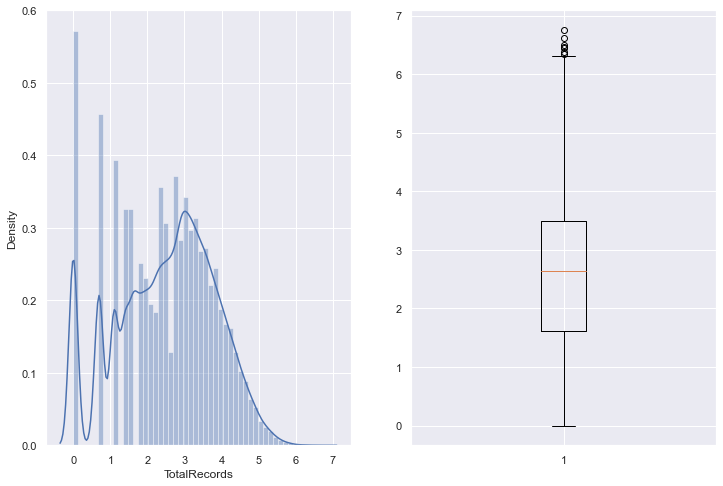


----- InteractionEnglish -----
count    158981.000000
mean          2.078451
std           2.439440
min           0.000000
25%           0.000000
50%           0.708036
75%           4.349762
max          12.123517
Name: InteractionEnglish, dtype: float64
* Variance: 5.950866665046817
* Median: 0.7080357930536961
* Skewness: 0.7350923532115881
* Kurtosis: -0.886673769652552
* Percentage of outliers: 4.4030418729282114e-05
* Number of missing value: 0


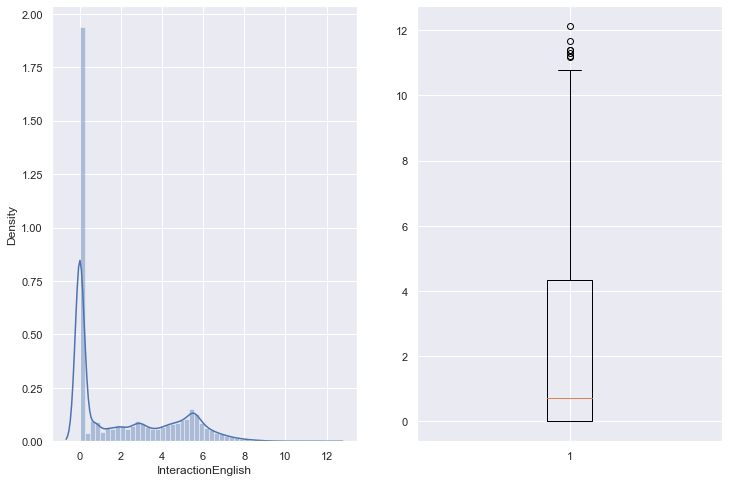


----- InteractionMath -----
count    158981.000000
mean          0.078298
std           0.599270
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.710479
Name: InteractionMath, dtype: float64
* Variance: 0.359124512947883
* Median: 0.0
* Skewness: 9.020446241711232
* Kurtosis: 88.19646745846588
* Percentage of outliers: 0.026789364766858934
* Number of missing value: 0


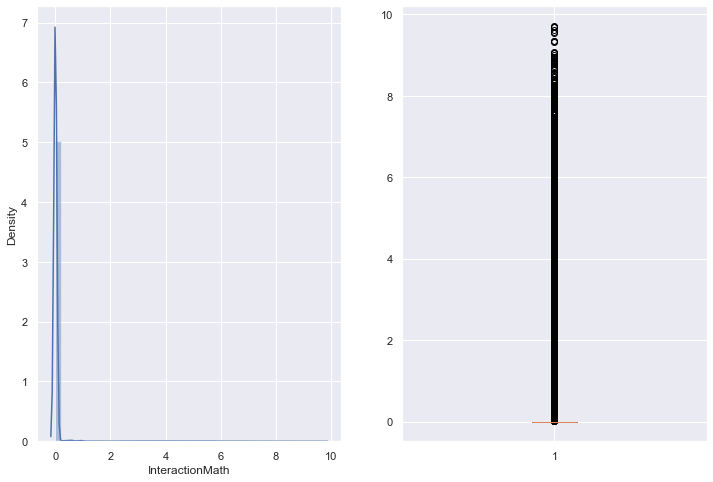


----- InteractionPhonics -----
count    158981.000000
mean          0.088503
std           0.604818
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.138558
Name: InteractionPhonics, dtype: float64
* Variance: 0.3658053090820987
* Median: 0.0
* Skewness: 8.005115984462657
* Kurtosis: 69.40428916939767
* Percentage of outliers: 0.030003585334096528
* Number of missing value: 0


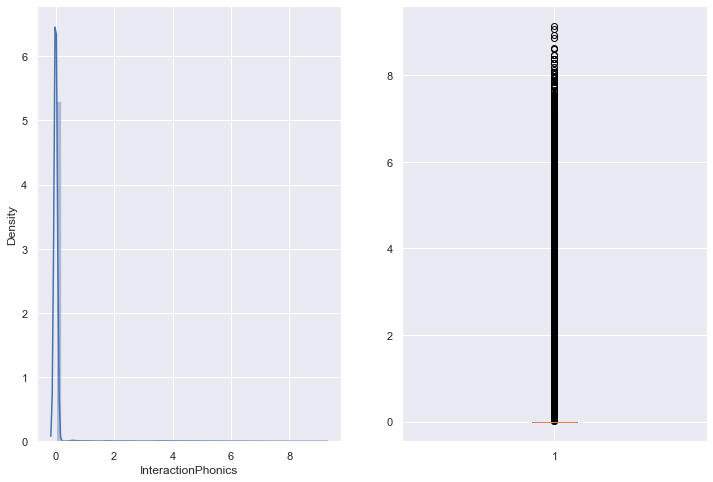


----- InteractionVietnamese -----
count    158981.000000
mean          2.211711
std           2.589991
min           0.000000
25%           0.000000
50%           0.815365
75%           4.419443
max          11.627483
Name: InteractionVietnamese, dtype: float64
* Variance: 6.708052638277527
* Median: 0.8153648132841944
* Skewness: 0.7925736210492111
* Kurtosis: -0.7425049459575033
* Percentage of outliers: 4.4030418729282114e-05
* Number of missing value: 0


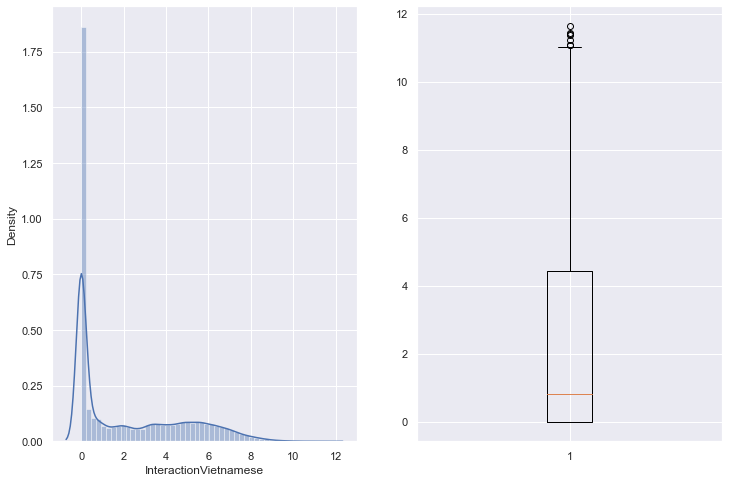


----- IsCompletedEnglish -----
count    158981.000000
mean          0.454243
std           0.477062
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.609438
Name: IsCompletedEnglish, dtype: float64
* Variance: 0.2275881292951361
* Median: 0.6931471805599453
* Skewness: 0.4772255171740357
* Kurtosis: -1.0002576518507613
* Percentage of outliers: 0.0
* Number of missing value: 0


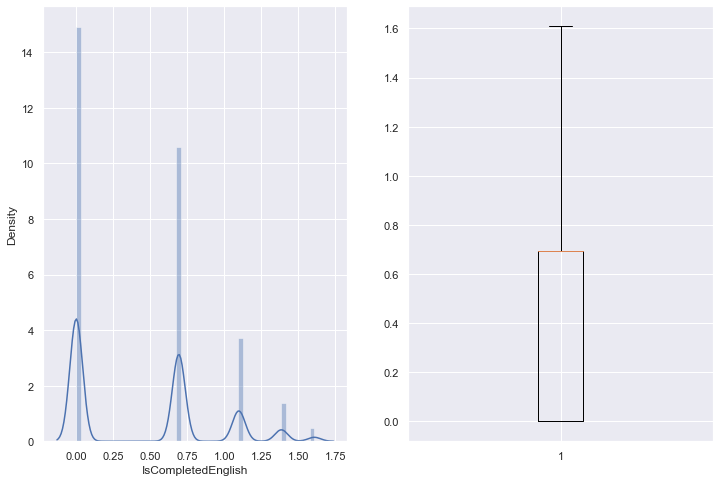


----- IsCompletedMath -----
count    158981.000000
mean          0.020358
std           0.133900
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.609438
Name: IsCompletedMath, dtype: float64
* Variance: 0.01792921876699334
* Median: 0.0
* Skewness: 7.107501577441522
* Kurtosis: 54.05082190413245
* Percentage of outliers: 0.024524943232210137
* Number of missing value: 0


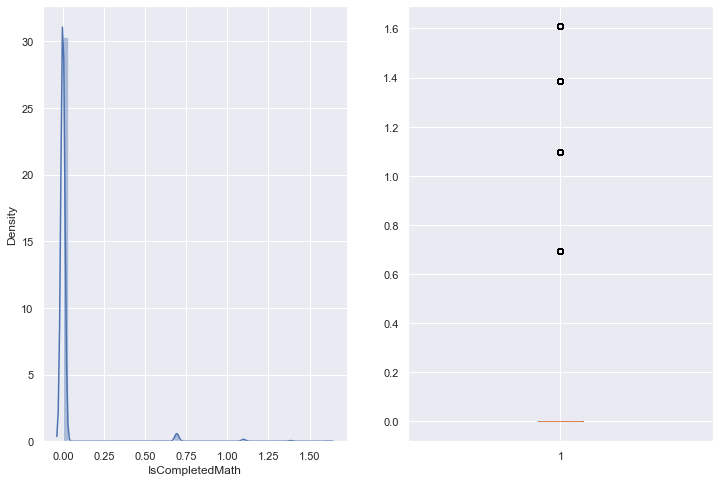


----- IsCompletedPhonics -----
count    158981.000000
mean          0.022221
std           0.137511
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.609438
Name: IsCompletedPhonics, dtype: float64
* Variance: 0.018909193648774532
* Median: 0.0
* Skewness: 6.608728423707895
* Kurtosis: 46.2455025394783
* Percentage of outliers: 0.02735547015052113
* Number of missing value: 0


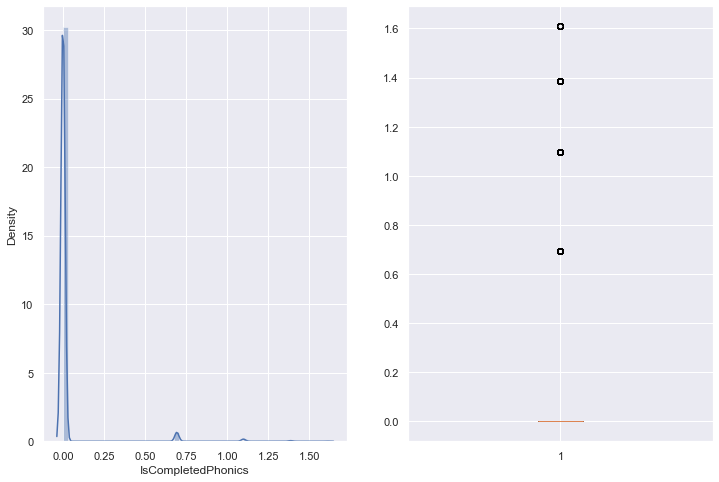


----- IsCompletedVietnamese -----
count    158981.000000
mean          0.472484
std           0.488991
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.609438
Name: IsCompletedVietnamese, dtype: float64
* Variance: 0.2391119151897167
* Median: 0.6931471805599453
* Skewness: 0.47727814456272766
* Kurtosis: -0.966450283567879
* Percentage of outliers: 0.0
* Number of missing value: 0


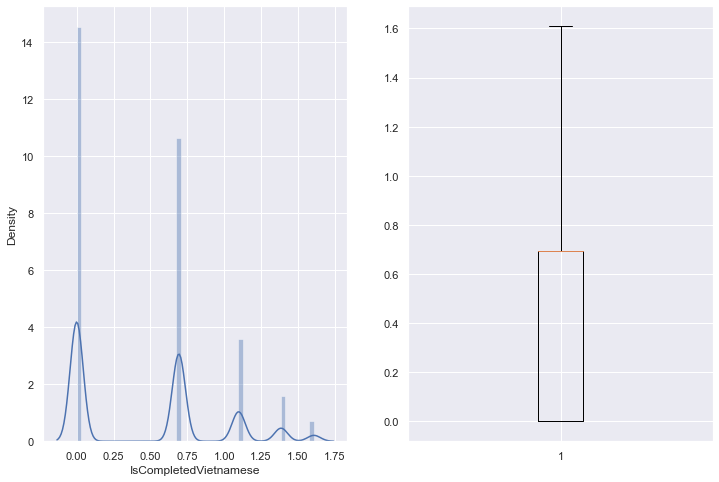


----- RecordEnglish -----
count    158981.000000
mean          1.299445
std           1.417122
min           0.000000
25%           0.000000
50%           0.693147
75%           2.639057
max           6.470800
Name: RecordEnglish, dtype: float64
* Variance: 2.0082360731116924
* Median: 0.6931471805599453
* Skewness: 0.5714412379218524
* Kurtosis: -1.0554830115793679
* Percentage of outliers: 0.0
* Number of missing value: 0


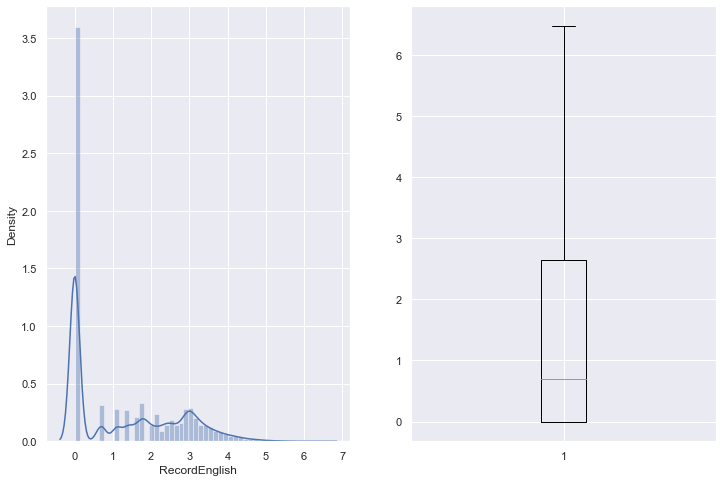


----- RecordMath -----
count    158981.000000
mean          0.051709
std           0.350889
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.283204
Name: RecordMath, dtype: float64
* Variance: 0.12312323938925356
* Median: 0.0
* Skewness: 7.8350955441941394
* Kurtosis: 66.6860476548975
* Percentage of outliers: 0.02680823494631434
* Number of missing value: 0


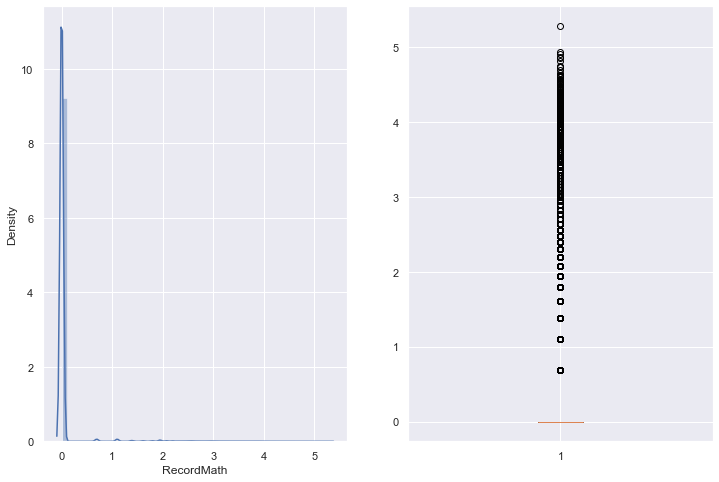


----- RecordPhonics -----
count    158981.000000
mean          0.056612
std           0.357935
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.342334
Name: RecordPhonics, dtype: float64
* Variance: 0.12811737664918682
* Median: 0.0
* Skewness: 7.226403358521123
* Kurtosis: 56.53657780777799
* Percentage of outliers: 0.03003503563318887
* Number of missing value: 0


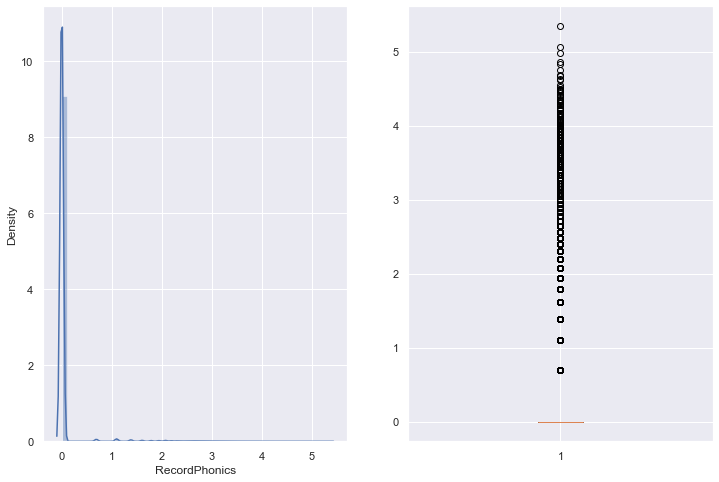


----- RecordVietnamese -----
count    158981.000000
mean          1.338028
std           1.434290
min           0.000000
25%           0.000000
50%           1.098612
75%           2.484907
max           6.614726
Name: RecordVietnamese, dtype: float64
* Variance: 2.0571878193993216
* Median: 1.0986122886681098
* Skewness: 0.6737033572936947
* Kurtosis: -0.7845824105519976
* Percentage of outliers: 3.145029909234437e-05
* Number of missing value: 0


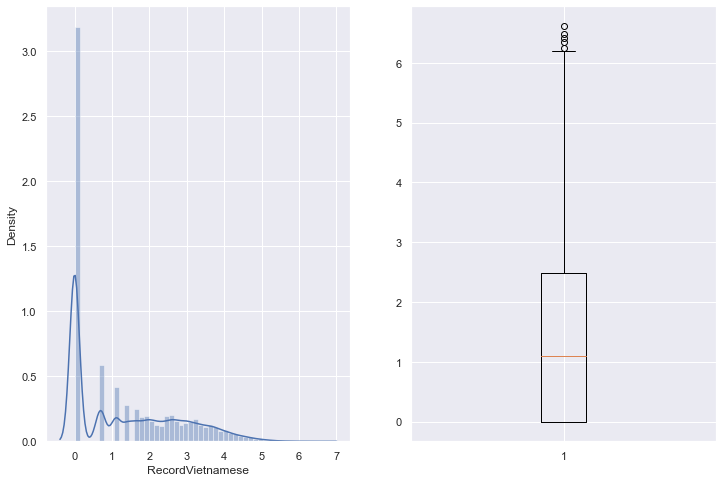


----- UsageTimeEnglish -----
count    158981.000000
mean          1.147070
std           1.303477
min           0.000000
25%           0.000000
50%           0.683097
75%           2.299581
max           7.290907
Name: UsageTimeEnglish, dtype: float64
* Variance: 1.6990518454098344
* Median: 0.6830968447064438
* Skewness: 0.7246217569586777
* Kurtosis: -0.7371892625416372
* Percentage of outliers: 0.00019499185437253509
* Number of missing value: 0


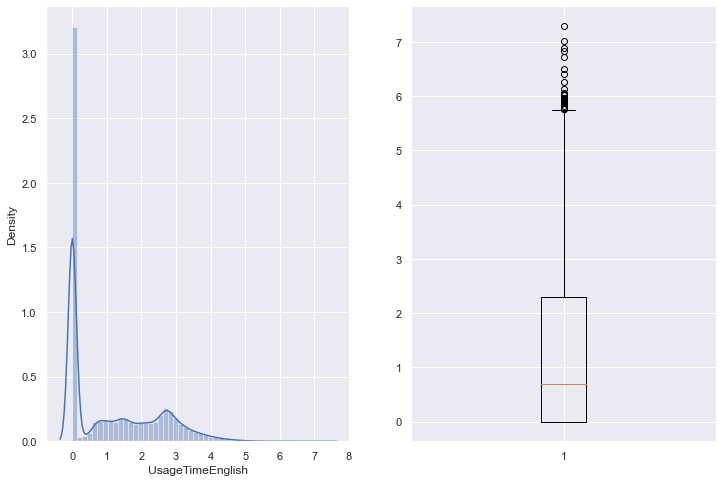


----- UsageTimeMath -----
count    158981.000000
mean          0.045555
std           0.338670
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.977746
Name: UsageTimeMath, dtype: float64
* Variance: 0.11469721158972074
* Median: 0.0
* Skewness: 8.953610252917121
* Kurtosis: 88.40672883632861
* Percentage of outliers: 0.026789364766858934
* Number of missing value: 0


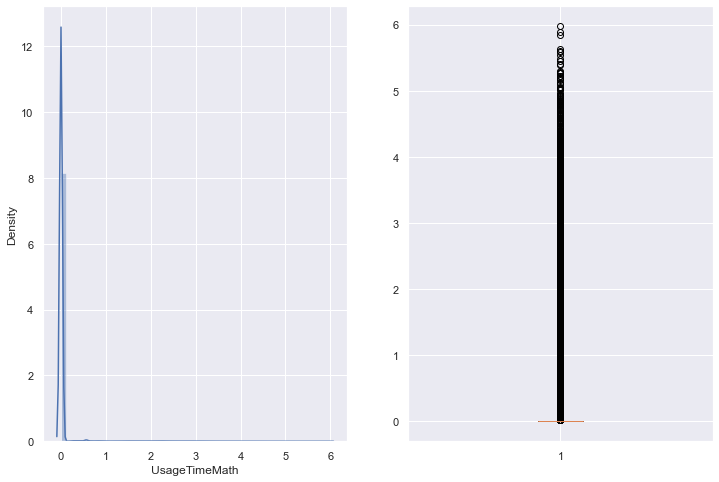


----- UsageTimePhonics -----
count    158981.000000
mean          0.054300
std           0.351194
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.164157
Name: UsageTimePhonics, dtype: float64
* Variance: 0.12333746566230883
* Median: 0.0
* Skewness: 7.419635415018529
* Kurtosis: 59.595594574556145
* Percentage of outliers: 0.030003585334096528
* Number of missing value: 0


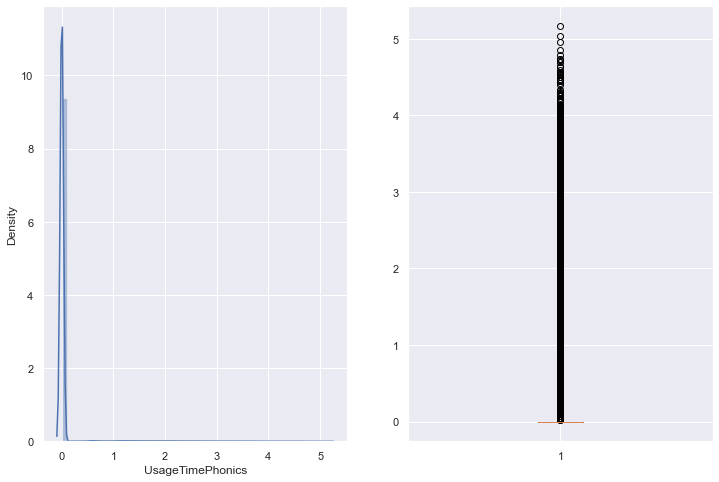


----- UsageTimeVietnamese -----
count    158981.000000
mean          1.257525
std           1.405597
min           0.000000
25%           0.000000
50%           0.683097
75%           2.437990
max           6.670094
Name: UsageTimeVietnamese, dtype: float64
* Variance: 1.975702909841991
* Median: 0.6830968447064438
* Skewness: 0.7260024181981721
* Kurtosis: -0.766391584169972
* Percentage of outliers: 5.6610538366219865e-05
* Number of missing value: 0


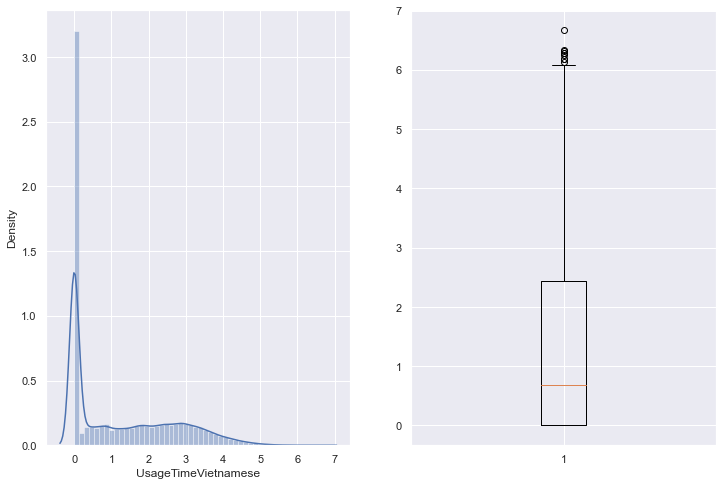


----- RecordDiscovery -----
count    158981.000000
mean          0.600245
std           0.870748
min           0.000000
25%           0.000000
50%           0.000000
75%           1.098612
max           5.262690
Name: RecordDiscovery, dtype: float64
* Variance: 0.7582026251066601
* Median: 0.0
* Skewness: 1.2532233923678193
* Kurtosis: 0.43943763754331
* Percentage of outliers: 0.0236632050370799
* Number of missing value: 0


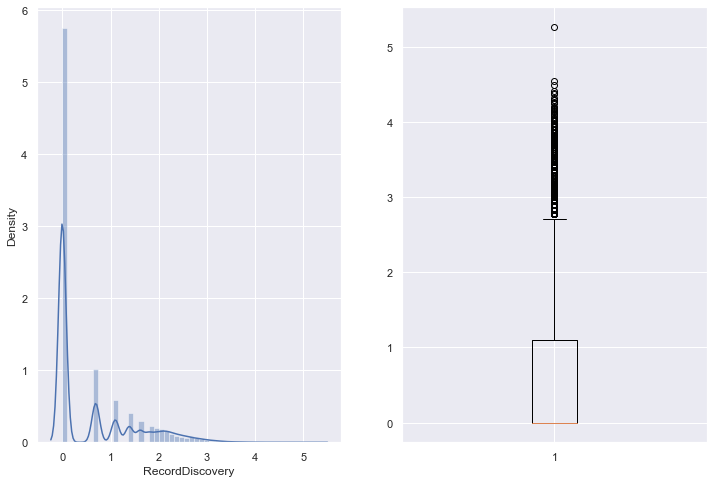


----- RecordEntertainment -----
count    158981.000000
mean          0.713422
std           1.022032
min           0.000000
25%           0.000000
50%           0.000000
75%           1.386294
max           5.905362
Name: RecordEntertainment, dtype: float64
* Variance: 1.0445495037384884
* Median: 0.0
* Skewness: 1.3174039367655497
* Kurtosis: 0.8300453983175902
* Percentage of outliers: 0.017800869286266913
* Number of missing value: 0


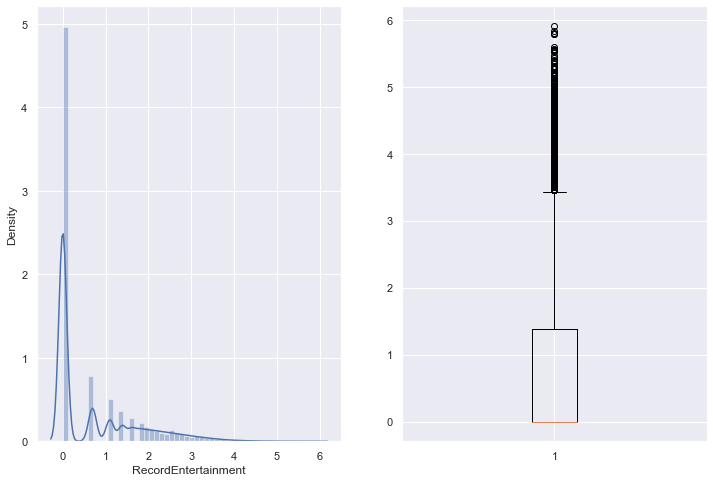


----- RecordLearn -----
count    158981.000000
mean          2.379771
std           1.226363
min           0.000000
25%           1.386294
50%           2.484907
75%           3.258097
max           6.614726
Name: RecordLearn, dtype: float64
* Variance: 1.503965219905205
* Median: 2.4849066497880004
* Skewness: -0.04455076569687282
* Kurtosis: -0.6638776903761601
* Percentage of outliers: 0.0001635415552801907
* Number of missing value: 0


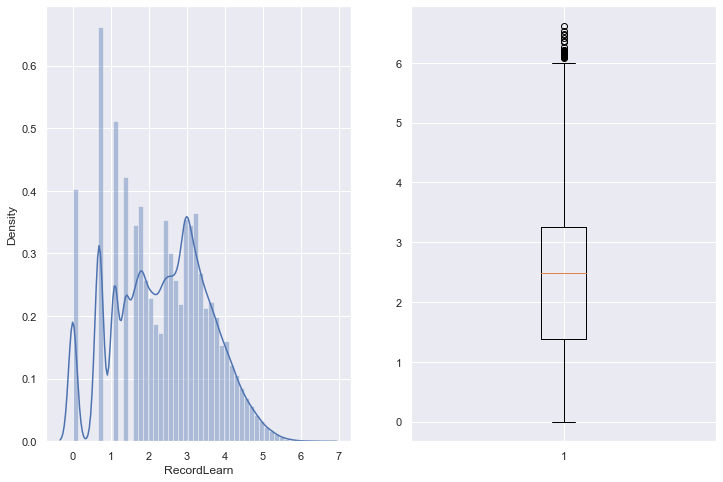


----- UsageTimeDiscovery -----
count    158981.000000
mean          0.784128
std           1.178618
min           0.000000
25%           0.000000
50%           0.000000
75%           1.574846
max           6.022212
Name: UsageTimeDiscovery, dtype: float64
* Variance: 1.3891393273710273
* Median: 0.0
* Skewness: 1.2129301930903094
* Kurtosis: 0.08335312328951794
* Percentage of outliers: 0.008523031054025325
* Number of missing value: 0


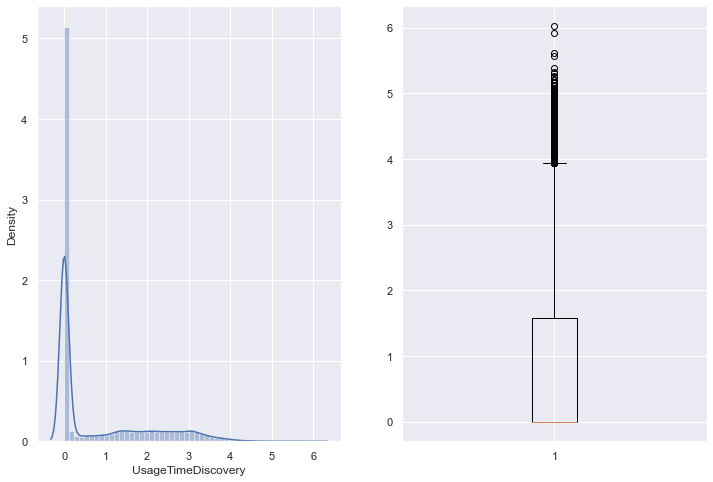


----- UsageTimeEntertainment -----
count    158981.000000
mean          0.798724
std           1.256527
min           0.000000
25%           0.000000
50%           0.000000
75%           1.381282
max           6.761631
Name: UsageTimeEntertainment, dtype: float64
* Variance: 1.5788612223748655
* Median: 0.0
* Skewness: 1.4885883163949138
* Kurtosis: 1.1207032953593923
* Percentage of outliers: 0.05835917499575421
* Number of missing value: 0


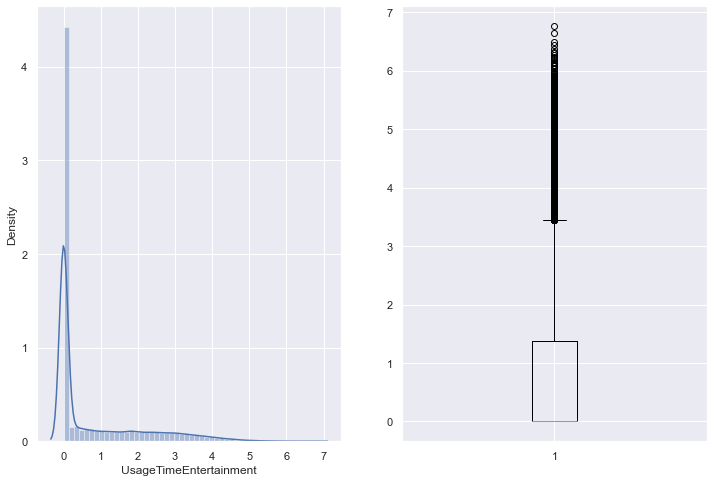


----- UsageTimeLearn -----
count    158981.000000
mean          2.186884
std           1.233924
min           0.000000
25%           1.199965
50%           2.266958
75%           3.086030
max           7.374322
Name: UsageTimeLearn, dtype: float64
* Variance: 1.5225688621892972
* Median: 2.2669579153508947
* Skewness: 0.02951534482614278
* Kurtosis: -0.7377189918647655
* Percentage of outliers: 0.0002704725721941616
* Number of missing value: 0


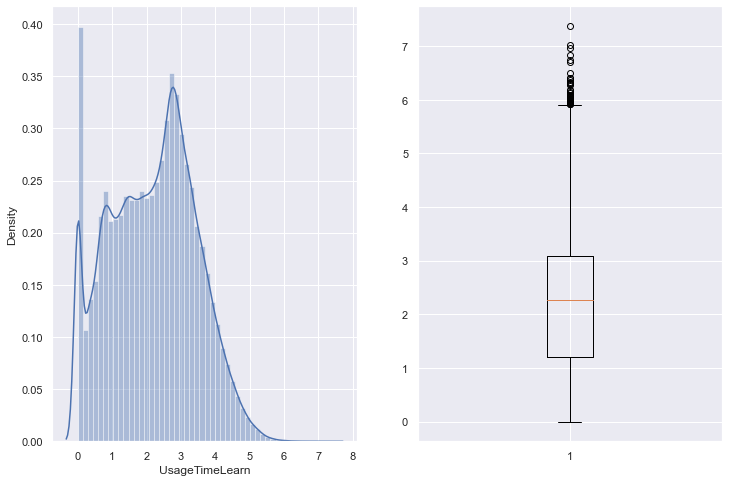


----- MedianUsageTime -----
count    158981.000000
mean          1.850815
std           0.832139
min           0.000000
25%           1.223775
50%           1.889340
75%           2.469793
max           5.448525
Name: MedianUsageTime, dtype: float64
* Variance: 0.692455697025238
* Median: 1.889339797566919
* Skewness: -0.011348368630781772
* Kurtosis: -0.5945735046996328
* Percentage of outliers: 0.0009183487334964556
* Number of missing value: 0


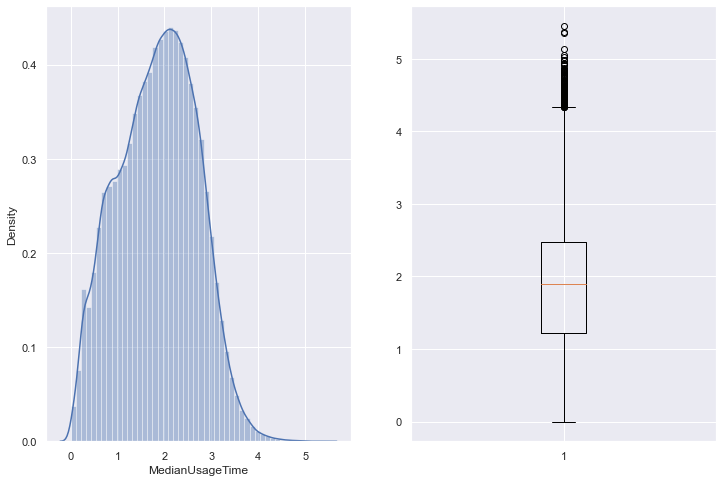


----- MedianRecord -----
count    158981.000000
mean          1.625749
std           0.931447
min           0.000000
25%           1.098612
50%           1.609438
75%           2.302585
max           5.231109
Name: MedianRecord, dtype: float64
* Variance: 0.8675929685742941
* Median: 1.6094379124341003
* Skewness: -0.020204939457357123
* Kurtosis: -0.5977690078575155
* Percentage of outliers: 0.0016228354331649694
* Number of missing value: 0


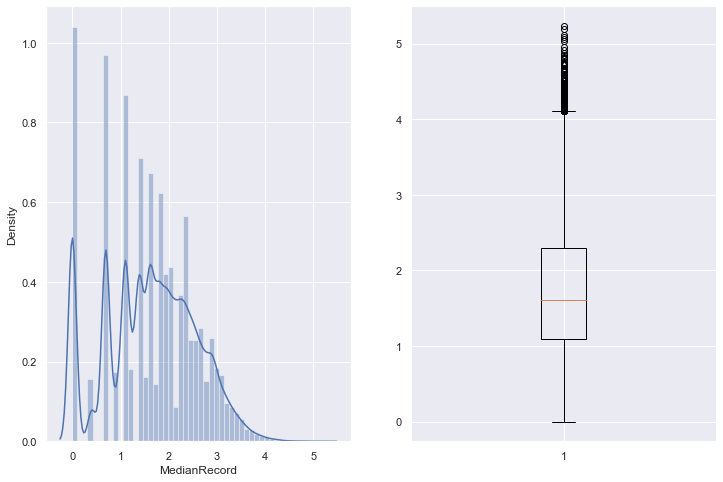


----- MedianPaymentScreen -----
count    158981.000000
mean          0.465870
std           0.669170
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.209486
Name: MedianPaymentScreen, dtype: float64
* Variance: 0.44778913249027535
* Median: 0.0
* Skewness: 1.4295136823289984
* Kurtosis: 1.6363137723937613
* Percentage of outliers: 0.06256722501430989
* Number of missing value: 0


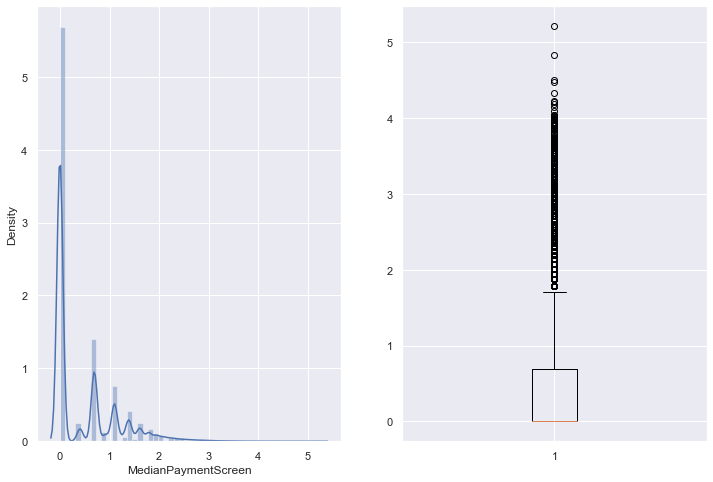


----- AvgTimePerCompletion -----
count    158981.000000
mean          0.677734
std           0.256327
min           0.000000
25%           0.523460
50%           0.634591
75%           0.799008
max           4.224934
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.06570371849086729
* Median: 0.6345907310999216
* Skewness: 1.1410442247049586
* Kurtosis: 3.493972901668496
* Percentage of outliers: 0.04301142903869016
* Number of missing value: 0


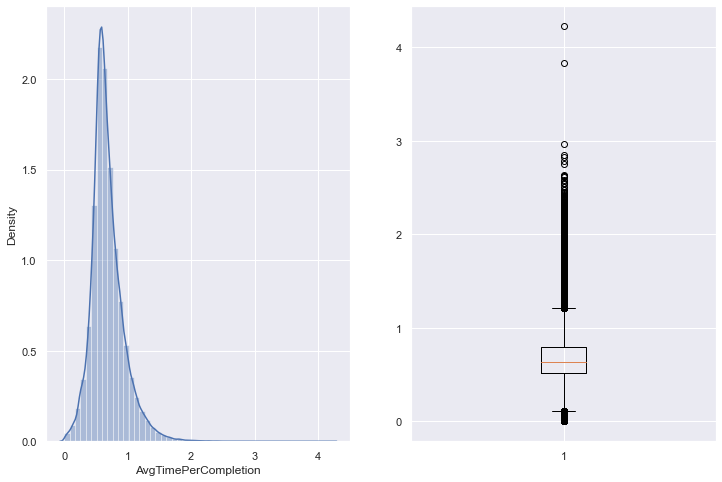


----- InteractionGeneral -----
count    158981.000000
mean          5.050458
std           2.608307
min           0.000000
25%           3.014554
50%           5.298817
75%           7.016655
max          13.765921
Name: InteractionGeneral, dtype: float64
* Variance: 6.803267991166231
* Median: 5.2988172415896875
* Skewness: -0.08989059489655638
* Kurtosis: -0.8282633402033523
* Percentage of outliers: 3.145029909234437e-05
* Number of missing value: 0


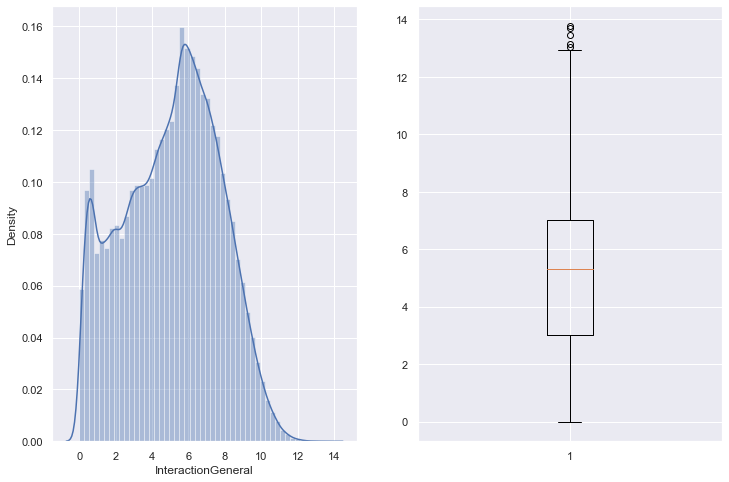


----- InteractionLearn -----
count    158981.000000
mean          4.310260
std           2.611193
min           0.000000
25%           2.116256
50%           4.521789
75%           6.248739
max          13.747015
Name: InteractionLearn, dtype: float64
* Variance: 6.818328243618764
* Median: 4.5217885770490405
* Skewness: 0.010946702755979018
* Kurtosis: -0.8949212511517488
* Percentage of outliers: 6.290059818468874e-05
* Number of missing value: 0


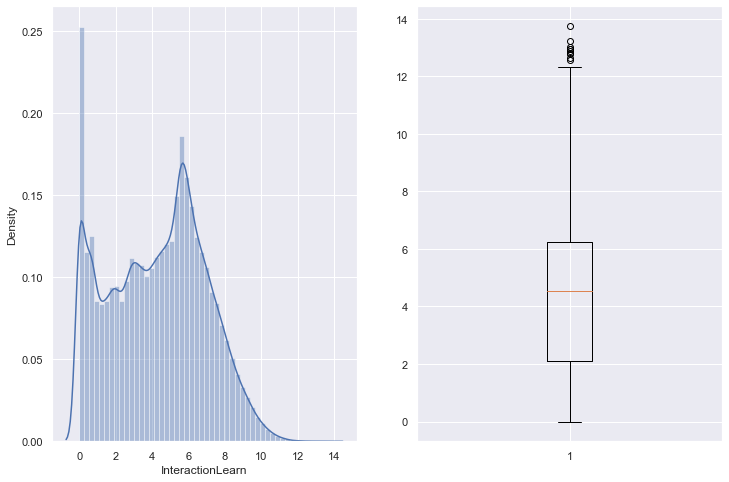


----- InteractionDiscovery -----
count    158981.000000
mean          1.219826
std           1.949366
min           0.000000
25%           0.000000
50%           0.000000
75%           2.135349
max          10.552410
Name: InteractionDiscovery, dtype: float64
* Variance: 3.800027610176522
* Median: 0.0
* Skewness: 1.442644668401048
* Kurtosis: 0.8309660447586151
* Percentage of outliers: 0.05763581811663029
* Number of missing value: 0


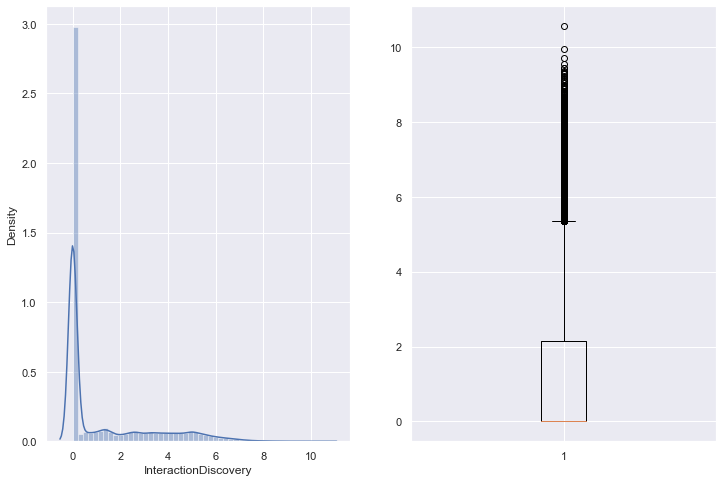


----- InteractionEntertainment -----
count    158981.000000
mean          1.340720
std           2.184363
min           0.000000
25%           0.000000
50%           0.000000
75%           2.198335
max          11.879209
Name: InteractionEntertainment, dtype: float64
* Variance: 4.771440848585603
* Median: 0.0
* Skewness: 1.5934173512703915
* Kurtosis: 1.5225165921431567
* Percentage of outliers: 0.0783867254577591
* Number of missing value: 0


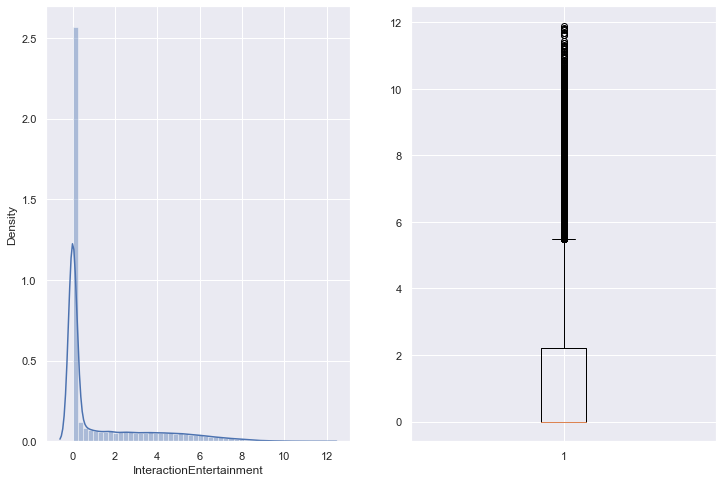


----- MedianInteraction -----
count    158981.000000
mean          3.355124
std           1.729905
min           0.000000
25%           2.016235
50%           3.405189
75%           4.640537
max          10.117788
Name: MedianInteraction, dtype: float64
* Variance: 2.9925704007380483
* Median: 3.405189402931693
* Skewness: 0.05133713797989388
* Kurtosis: -0.6854799890518377
* Percentage of outliers: 0.0006038457425730119
* Number of missing value: 0


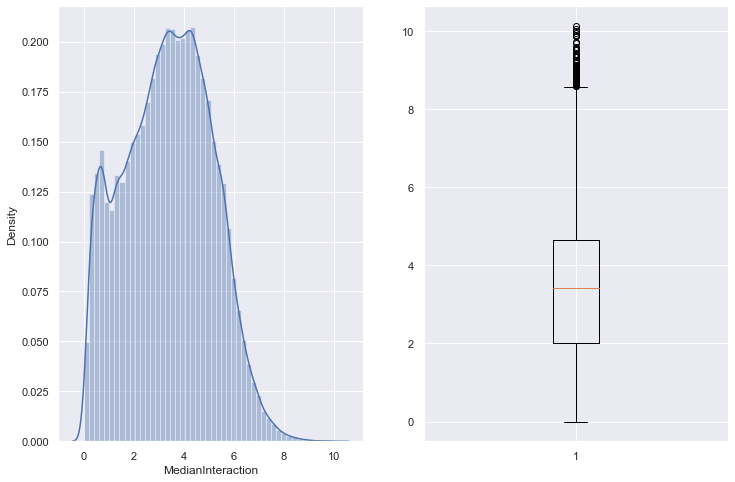

In [35]:
for col in data.columns[1:]:
    if col not in excludes:
        fc.continuous_analysis(data, col)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UserID                    158981 non-null  object 
 1   Recency                   158981 non-null  int64  
 2   ContentFrequent           158981 non-null  int64  
 3   PaymentScreenFrequent     158981 non-null  int64  
 4   TotalUsageTime            158981 non-null  float64
 5   TotalRecords              158981 non-null  float64
 6   ModeFirstHour             158981 non-null  int64  
 7   ModeLastHour              158981 non-null  int64  
 8   ModeLastDay               158981 non-null  int64  
 9   ModeDayofweek             158981 non-null  int64  
 10  TotalChild                158981 non-null  float64
 11  MedianChildAge            158981 non-null  float64
 12  No.Female                 158981 non-null  float64
 13  No.Male                   158981 non-null  f

In [136]:
X = data.drop(['UserID', 'Label', 'firstPaymentType', 'gapday'], axis = 1)
y = data['Label']

In [137]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [39]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [138]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [169]:
sw = fc.BinarySampleWeights(X_train.shape[0], y_train)
sw_zen = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'zen')
sw_isns = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'isns')
sw_eff = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'ens', beta = 0.99999)

In [191]:
sw_isns

array([0.0029, 0.0109])

In [139]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.940236193231853

In [140]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9399

* Confusion Matrix: 
[[29588   104]
 [ 1806   299]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29692
           1       0.74      0.14      0.24      2105

    accuracy                           0.94     31797
   macro avg       0.84      0.57      0.60     31797
weighted avg       0.93      0.94      0.92     31797



In [141]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 100,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9275380551012706

In [142]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9229

* Confusion Matrix: 
[[28218  1474]
 [  978  1127]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29692
           1       0.43      0.54      0.48      2105

    accuracy                           0.92     31797
   macro avg       0.70      0.74      0.72     31797
weighted avg       0.93      0.92      0.93     31797



In [149]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 300,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.94393948924393

In [150]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9269

* Confusion Matrix: 
[[28400  1292]
 [ 1031  1074]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29692
           1       0.45      0.51      0.48      2105

    accuracy                           0.93     31797
   macro avg       0.71      0.73      0.72     31797
weighted avg       0.93      0.93      0.93     31797



ROC AUC score: 0.7334


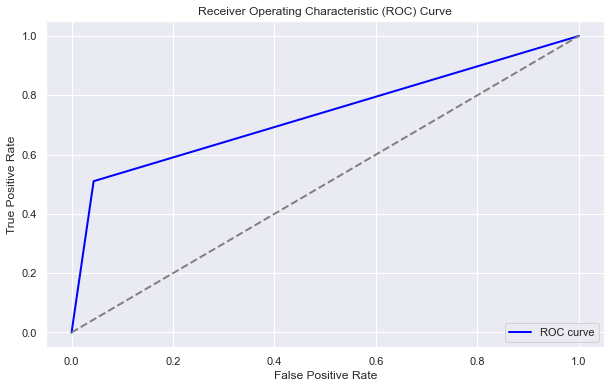

In [151]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [173]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5.5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9304865391873192

In [174]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9205

* Confusion Matrix: 
[[28136  1556]
 [  973  1132]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29692
           1       0.42      0.54      0.47      2105

    accuracy                           0.92     31797
   macro avg       0.69      0.74      0.71     31797
weighted avg       0.93      0.92      0.92     31797



ROC AUC score: 0.7427


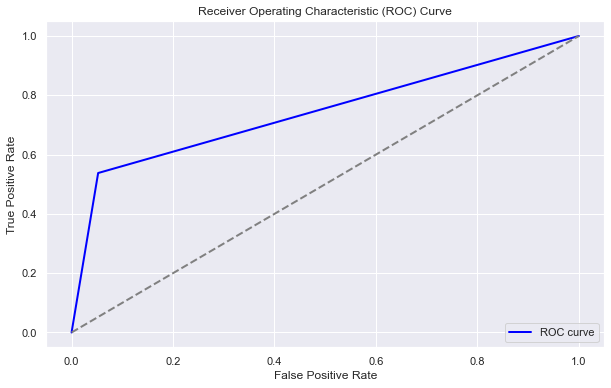

In [175]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [170]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9413212353755189

In [171]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9339

* Confusion Matrix: 
[[28676  1016]
 [ 1087  1018]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     29692
           1       0.50      0.48      0.49      2105

    accuracy                           0.93     31797
   macro avg       0.73      0.72      0.73     31797
weighted avg       0.93      0.93      0.93     31797



ROC AUC score: 0.7247


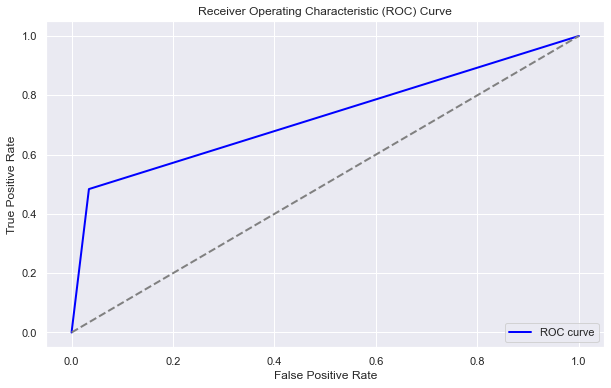

In [172]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [80]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9588234369103031

In [81]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9327

* Confusion Matrix: 
[[28636  1101]
 [ 1039  1021]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.48      0.50      0.49      2060

    accuracy                           0.93     31797
   macro avg       0.72      0.73      0.73     31797
weighted avg       0.93      0.93      0.93     31797



ROC AUC score: 0.7293


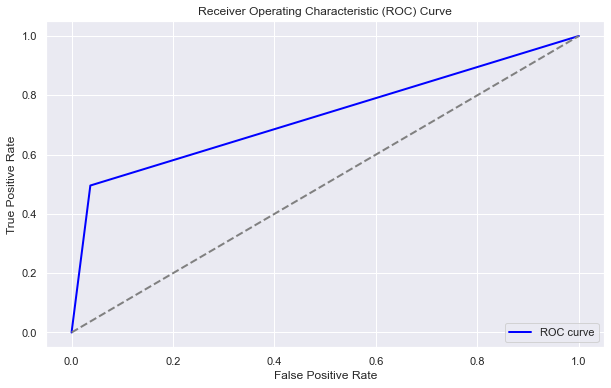

In [82]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [83]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.853440684362813

In [84]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.841

* Confusion Matrix: 
[[25261  4476]
 [  579  1481]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     29737
           1       0.25      0.72      0.37      2060

    accuracy                           0.84     31797
   macro avg       0.61      0.78      0.64     31797
weighted avg       0.93      0.84      0.87     31797



ROC AUC score: 0.7842


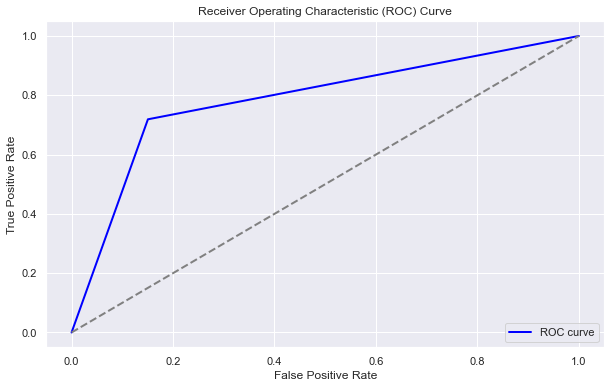

In [85]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [86]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9280019499308089

In [87]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9227

* Confusion Matrix: 
[[28212  1525]
 [  932  1128]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.43      0.55      0.48      2060

    accuracy                           0.92     31797
   macro avg       0.70      0.75      0.72     31797
weighted avg       0.93      0.92      0.93     31797



ROC AUC score: 0.7481


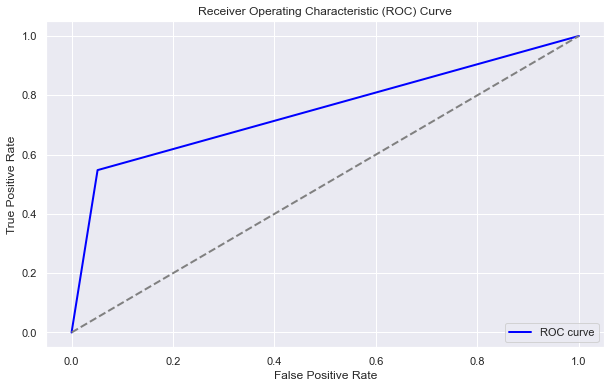

In [88]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [89]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()

gauss_model = gauss.fit(X_train, y_train)
gauss_model.score(X_train, y_train)

0.7969949050194993

In [90]:
fc.eval_clf_testset(gauss_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7943

* Confusion Matrix: 
[[23974  5763]
 [  778  1282]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     29737
           1       0.18      0.62      0.28      2060

    accuracy                           0.79     31797
   macro avg       0.58      0.71      0.58     31797
weighted avg       0.92      0.79      0.84     31797



In [91]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)

tree_clf = tree.fit(X_train, y_train)
tree_clf.score(X_train, y_train)

1.0

In [92]:
fc.eval_clf_testset(tree_clf, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9068

* Confusion Matrix: 
[[28125  1612]
 [ 1353   707]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.30      0.34      0.32      2060

    accuracy                           0.91     31797
   macro avg       0.63      0.64      0.64     31797
weighted avg       0.91      0.91      0.91     31797



In [93]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.7745628380928419

In [94]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7734

* Confusion Matrix: 
[[23078  6659]
 [  547  1513]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.78      0.86     29737
           1       0.19      0.73      0.30      2060

    accuracy                           0.77     31797
   macro avg       0.58      0.76      0.58     31797
weighted avg       0.93      0.77      0.83     31797



In [95]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.7730925273619323

In [96]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7725

* Confusion Matrix: 
[[23045  6692]
 [  541  1519]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     29737
           1       0.18      0.74      0.30      2060

    accuracy                           0.77     31797
   macro avg       0.58      0.76      0.58     31797
weighted avg       0.93      0.77      0.83     31797



In [97]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9230878097873947

In [98]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9251

* Confusion Matrix: 
[[28531  1206]
 [ 1176   884]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.42      0.43      0.43      2060

    accuracy                           0.93     31797
   macro avg       0.69      0.69      0.69     31797
weighted avg       0.93      0.93      0.93     31797



In [99]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.8527094603094729

In [100]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8536

* Confusion Matrix: 
[[25845  3892]
 [  762  1298]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     29737
           1       0.25      0.63      0.36      2060

    accuracy                           0.85     31797
   macro avg       0.61      0.75      0.64     31797
weighted avg       0.92      0.85      0.88     31797



In [101]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [102]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9107

* Confusion Matrix: 
[[28266  1471]
 [ 1368   692]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.32      0.34      0.33      2060

    accuracy                           0.91     31797
   macro avg       0.64      0.64      0.64     31797
weighted avg       0.91      0.91      0.91     31797



In [103]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [104]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9108

* Confusion Matrix: 
[[28277  1460]
 [ 1375   685]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.32      0.33      0.33      2060

    accuracy                           0.91     31797
   macro avg       0.64      0.64      0.64     31797
weighted avg       0.91      0.91      0.91     31797



In [105]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [106]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9083

* Confusion Matrix: 
[[28189  1548]
 [ 1367   693]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.31      0.34      0.32      2060

    accuracy                           0.91     31797
   macro avg       0.63      0.64      0.64     31797
weighted avg       0.91      0.91      0.91     31797



In [107]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [108]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9105

* Confusion Matrix: 
[[28258  1479]
 [ 1367   693]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.32      0.34      0.33      2060

    accuracy                           0.91     31797
   macro avg       0.64      0.64      0.64     31797
weighted avg       0.91      0.91      0.91     31797



In [109]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42, n_estimators = 100)
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999685495030821

In [110]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9482

* Confusion Matrix: 
[[29632   105]
 [ 1542   518]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29737
           1       0.83      0.25      0.39      2060

    accuracy                           0.95     31797
   macro avg       0.89      0.62      0.68     31797
weighted avg       0.94      0.95      0.93     31797



In [111]:
forest = RandomForestClassifier(random_state = 42, n_estimators = 100, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999764121273116

In [112]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9475

* Confusion Matrix: 
[[29649    88]
 [ 1581   479]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29737
           1       0.84      0.23      0.36      2060

    accuracy                           0.95     31797
   macro avg       0.90      0.61      0.67     31797
weighted avg       0.94      0.95      0.93     31797



In [113]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9397015347842496

In [114]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9349

* Confusion Matrix: 
[[28699  1038]
 [ 1032  1028]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.50      0.50      0.50      2060

    accuracy                           0.93     31797
   macro avg       0.73      0.73      0.73     31797
weighted avg       0.93      0.93      0.93     31797



In [117]:
data.to_csv('ICK_Active3thdays.csv', index=False)

In [118]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [119]:
class_weights_dict = dict(enumerate(class_weights))

In [120]:
class_weights_dict

{0: 0.5346379160753559, 1: 7.717524271844661}

In [121]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = class_weights_dict,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.837455969304315

In [122]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8322

* Confusion Matrix: 
[[24948  4789]
 [  548  1512]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     29737
           1       0.24      0.73      0.36      2060

    accuracy                           0.83     31797
   macro avg       0.61      0.79      0.63     31797
weighted avg       0.93      0.83      0.87     31797



In [123]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.9602151213989181

In [124]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.949

* Confusion Matrix: 
[[29552   185]
 [ 1436   624]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.77      0.30      0.43      2060

    accuracy                           0.95     31797
   macro avg       0.86      0.65      0.70     31797
weighted avg       0.94      0.95      0.94     31797



In [125]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 900,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            objective='binary:logistic',
                            max_depth=3,
                            n_jobs=-1,
                            verbosity=0)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.9380582463202919

In [126]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9262

* Confusion Matrix: 
[[28357  1380]
 [  966  1094]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.44      0.53      0.48      2060

    accuracy                           0.93     31797
   macro avg       0.70      0.74      0.72     31797
weighted avg       0.93      0.93      0.93     31797



In [97]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')

X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [98]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9878220002690342

In [99]:
fc.eval_clf_testset(lgbm_model, X_train, y_train)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9775

* Confusion Matrix: 
[[116936   2008]
 [   848   7392]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    118944
           1       0.79      0.90      0.84      8240

    accuracy                           0.98    127184
   macro avg       0.89      0.94      0.91    127184
weighted avg       0.98      0.98      0.98    127184



In [100]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.928

* Confusion Matrix: 
[[28601  1136]
 [ 1154   906]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.44      0.44      0.44      2060

    accuracy                           0.93     31797
   macro avg       0.70      0.70      0.70     31797
weighted avg       0.93      0.93      0.93     31797



In [101]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9283486346516008

In [102]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8652

* Confusion Matrix: 
[[26249  3488]
 [  797  1263]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     29737
           1       0.27      0.61      0.37      2060

    accuracy                           0.87     31797
   macro avg       0.62      0.75      0.65     31797
weighted avg       0.92      0.87      0.89     31797

